# Transfer Learning



## Google Drive Settings



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir('/content/drive/My Drive/Colab Notebooks/icdss')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

# Load the TensorBoard notebook extension.
%load_ext tensorboard

TensorFlow 2.x selected.


## Data Preprocessing

In [ ]:
#Import libraries
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import matplotlib.pyplot as plt
from reader import get_images
from keras import utils
from sklearn.model_selection import train_test_split
import scipy
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import sklearn.metrics

Using TensorFlow backend.


In [ ]:
#import dataset
(x_train, y_train_raw), (x_test, y_test_raw) = get_images() 

#convert training and test images into three channels
x_train = np.dstack([x_train]*3)
x_test = np.dstack([x_test]*3)

# Reshape data to image's dimension 28 by 28
x_train = x_train.reshape(-1,28,28,3)
x_test = x_test.reshape(-1,28,28,3)
x_train = x_train.astype(np.float32)
x_test = x_test.astype(np.float32)


/content/drive/My Drive/Colab Notebooks/icdss/reader.py:38: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  x_train = df_train.drop('label', axis=1).as_matrix().astype(np.uint8)
/content/drive/My Drive/Colab Notebooks/icdss/reader.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  y_train = df_train['label'].as_matrix().astype(np.uint8)
/content/drive/My Drive/Colab Notebooks/icdss/reader.py:40: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  x_test = df_test.drop('label', axis=1).as_matrix().astype(np.uint8)
/content/drive/My Drive/Colab Notebooks/icdss/reader.py:41: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  y_test = df_test['label'].as_matrix().astype(np.uint8)


In [ ]:
#Change classes to a categorical type
num_classes = 10
y_train = utils.to_categorical(y_train_raw, num_classes)
y_test = utils.to_categorical(y_test_raw, num_classes)

# split original training data to 80 % training data and the other 20% for validation data
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=13)

# Check the data size
x_train.shape, x_val.shape, y_train.shape, y_val.shape

((48000, 28, 28, 3), (12000, 28, 28, 3), (48000, 10), (12000, 10))

## Data Augmentation

In [ ]:
# Random Erasing Data Augmentation
def get_random_eraser(p=0.5, s_l=0.02, s_h=0.1, r_1=0.1, r_2=1/0.1, v_l=0, v_h=1, pixel_level=True):
    def eraser(input_img):
        img_h, img_w, img_c = input_img.shape
        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        if pixel_level:
            c = np.random.uniform(v_l, v_h, (h, w, img_c))
        else:
            c = np.random.uniform(v_l, v_h)

        input_img[top:top + h, left:left + w, :] = c

        return input_img

    return eraser

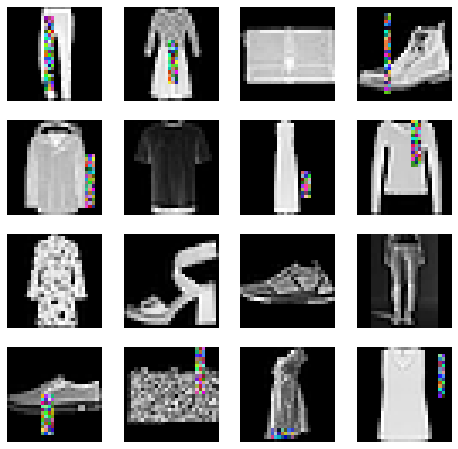

In [ ]:
eraser = get_random_eraser()
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(8, 8)

for i, img in enumerate(x_train[:16]):
    # Set up subplot; subplot indices start at 1
    sp = plt.subplot(4, 4, i + 1)
    sp.axis('Off') # Don't show axes (or gridlines)
    
    plt.imshow(eraser(img/255))

plt.show()

In [ ]:
# All images will be rescaled by 1./255. We apply data augmentation here.
train_datagen = ImageDataGenerator(rescale=1./255,
                                   horizontal_flip=True,
                                   width_shift_range=0.1,  
                                   height_shift_range=0.1, 
                                   fill_mode='nearest',
                                   preprocessing_function=get_random_eraser(v_l=0, v_h=1))
val_datagen = ImageDataGenerator(rescale=1./255,  
                                  fill_mode='nearest')

# Batch size
bs = 32
# Flow training images in batches of 32 using train_datagen generator
print("Preparing generator for train dataset")
train_generator = train_datagen.flow(x_train, 
                                     y_train, 
                                     batch_size=bs)

# Flow validation images in batches of 32 using val_datagen generator
print("Preparing generator for validation dataset")
val_generator = val_datagen.flow(x_val, 
                                 y_val,
                                 batch_size=bs)

Preparing generator for train dataset
Preparing generator for validation dataset


## Building the Model

In [ ]:
# Here we specify the input shape of our data 
# This should match the size of images ('image_size') along with the number of channels (3)
input_shape = (150, 150, 3)

# Define the number of classes
num_classes = 10

#ResNet50 Transfer Learning
base_model = tf.keras.applications.InceptionV3(include_top=False, 
                                            weights='imagenet', 
                                            input_shape=input_shape)



# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))
base_model.summary()

87916544/87910968 [==============================] - 3s 0us/step
Number of layers in the base model:  311
Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d_12 (Conv2D)              (None, 74, 74, 32)   864         input_11[0][0]                   
__________________________________________________________________________________________________
batch_normalization_12 (BatchNo (None, 74, 74, 32)   96          conv2d_12[0][0]                  
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normaliza

In [ ]:
input_img = tf.keras.Input(shape=(28, 28, 3))

x = tf.keras.layers.Lambda(lambda image: tf.image.resize(image, (150, 150)))(input_img)

x = base_model(x)

x = tf.keras.layers.GlobalAveragePooling2D()(x)

x = tf.keras.layers.Dense(512)(x) 

x = tf.keras.layers.LeakyReLU(alpha=0.3)(x)

x = tf.keras.layers.Dropout(0.5)(x)

predictions = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

model = tf.keras.Model(inputs=input_img, outputs=predictions)
model.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 28, 28, 3)]       0         
_________________________________________________________________
lambda_6 (Lambda)            (None, 150, 150, 3)       0         
_________________________________________________________________
inception_v3 (Model)         (None, 3, 3, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_5 ( (None, 2048)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 512)               1049088   
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0   

In [ ]:
# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
base_model.trainable = False

In [ ]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.5e-6)
bestValidationCheckpointer = ModelCheckpoint('train_model_inception_net.hdf5', monitor='val_loss', save_best_only=True, verbose=1)

In [ ]:
Adam = tf.keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.00, amsgrad=False)
SGD = tf.keras.optimizers.SGD(lr=0.001, momentum=0.9, decay=1e-6, nesterov=True)
model.compile(loss='categorical_crossentropy',
              optimizer=Adam,
              metrics=['accuracy'])

In [ ]:
history = model.fit_generator(train_generator, 
                              epochs=3,
                              validation_data=val_generator, 
                              callbacks=[bestValidationCheckpointer, reduce_lr],
                              verbose = 1)

Epoch 1/3
1499/1500 [============================>.] - ETA: 0s - loss: 1.3795 - accuracy: 0.5447
Epoch 00001: val_loss improved from inf to 1.48233, saving model to train_model_check.hdf5
1500/1500 [==============================] - 429s 286ms/step - loss: 1.3794 - accuracy: 0.5447 - val_loss: 1.4823 - val_accuracy: 0.6014
Epoch 2/3
  47/1500 [..............................] - ETA: 6:26 - loss: 1.2348 - accuracy: 0.5718

KeyboardInterrupt: ignored

In [ ]:
# Plot the chart for accuracy and loss on both training and validation

import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Fine Tuning

In [ ]:
base_model.trainable = True
for layer in base_model.layers[:50]:
    layer.trainable = False

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer=SGD,
              metrics=['acc'])

history2 = model.fit_generator(train_generator, 
                               epochs=3,
                               validation_data=val_generator, 
                               callbacks=[bestValidationCheckpointer, reduce_lr],
                               verbose = 1)

Epoch 1/20
749/750 [============================>.] - ETA: 0s - loss: 0.7370 - acc: 0.7364
Epoch 00001: val_loss did not improve from 0.93525
750/750 [==============================] - 775s 1s/step - loss: 0.7372 - acc: 0.7365 - val_loss: 1.5057 - val_acc: 0.5104
Epoch 2/20
749/750 [============================>.] - ETA: 0s - loss: 0.6601 - acc: 0.7615
Epoch 00002: val_loss did not improve from 0.93525
750/750 [==============================] - 773s 1s/step - loss: 0.6601 - acc: 0.7615 - val_loss: 1.4615 - val_acc: 0.5304
Epoch 3/20
749/750 [============================>.] - ETA: 0s - loss: 0.6231 - acc: 0.7711
Epoch 00003: val_loss did not improve from 0.93525
750/750 [==============================] - 774s 1s/step - loss: 0.6229 - acc: 0.7711 - val_loss: 1.3805 - val_acc: 0.5516
Epoch 4/20
749/750 [============================>.] - ETA: 0s - loss: 0.5922 - acc: 0.7842
Epoch 00004: val_loss did not improve from 0.93525
750/750 [==============================] - 773s 1s/step - loss: 0.

In [ ]:
# Plot the chart for accuracy and loss on both training and validation

import matplotlib.pyplot as plt
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']
loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])